In [131]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import ncx2, rv_continuous
from scipy.special import iv
from simple_pe.waveforms import two_ecc_harms_SNR

Given a true value of the SNR $\hat{\rho}$ of a signal we expect to measure an observed SNR $\rho$ in stationary gaussian noise, where $\rho^2$ is distributed according to a non-central chi-squared distribution with two degrees of freedom and a non-centrality parameter equal to $\hat{\rho}^2$.

For the phase consistent SNR combination, we expect $\rho_{1,-1}^2$ to (approximately) follow a non-central chi-squared distribution with three degrees of freedom (one phase, two amplitude) and a non-centrality parameter equal to $\hat{\rho}_{1,-1}^2$.

In order to verify these statements, let's generate a bunch of samples corresponding to $z_1$, $z_{-1}$, and $z_{1,-1}$, where $z_x = \rho_x e^{i \phi_x}$.

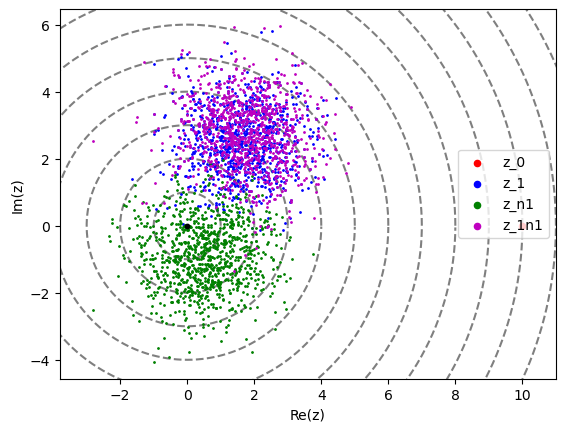

In [2]:
# Initial parameters
z_0 = 10*np.exp(1j*0)
z_1 = 3*np.exp(1j*1)
z_n1 = 1*np.exp(1j*-1)
z_1n1_abs, z_1n1_angle = two_ecc_harms_SNR({0: np.abs(z_0), 1: np.abs(z_1), -1: np.abs(z_n1)},
                                           {0: np.angle(z_0), 1: np.angle(z_1), -1: np.angle(z_n1)})
z_1n1 = np.abs(z_0)*z_1n1_abs*np.exp(1j*z_1n1_angle)

# Generate samples
samples_1 = np.random.normal(loc=np.real(z_1), size=10**6) + 1j*np.random.normal(loc=np.imag(z_1), size=10**6)
samples_n1 = np.random.normal(loc=np.real(z_n1), size=10**6) + 1j*np.random.normal(loc=np.imag(z_n1), size=10**6)
samples_1n1_abs, samples_1n1_angle = two_ecc_harms_SNR({0: np.full(len(samples_1), np.abs(z_0)), 1: np.abs(samples_1), -1: np.abs(samples_n1)},
                                                       {0: np.full(len(samples_1), np.angle(z_0)), 1: np.angle(samples_1), -1: np.angle(samples_n1)})
samples_1n1 = np.abs(z_0)*samples_1n1_abs*np.exp(1j*samples_1n1_angle)

# Plot samples
plt.gca().axis('equal')
plt.scatter(np.real(z_0), np.imag(z_0), c='r', s=20, label='z_0')
plt.scatter(np.real(samples_1[::1000]), np.imag(samples_1[::1000]), s=1, c='b')
plt.scatter(np.real(samples_n1[::1000]), np.imag(samples_n1[::1000]), s=1, c='g')
plt.scatter(np.real(samples_1n1[::1000]), np.imag(samples_1n1[::1000]), s=1, c='m')
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.scatter(0, 0, c='k', s=10)
circle_angs = np.linspace(0, 2*np.pi, 1000, endpoint=False)
for i in range(1, 2*int(np.ceil(np.abs(z_0)))+1):
    circle = i*np.exp(1j*circle_angs)
    plt.plot(np.real(circle), np.imag(circle), c='k', ls='dashed', alpha=0.5, zorder=-1)
plt.scatter(xlim[1]*2, ylim[1]*2, c='b', s=20, label='z_1')
plt.scatter(xlim[1]*2, ylim[1]*2, c='g', s=20, label='z_n1')
plt.scatter(xlim[1]*2, ylim[1]*2, c='m', s=20, label='z_1n1')
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend()
plt.xlabel('Re(z)')
plt.ylabel('Im(z)')
plt.show()

We can now plot $\rho^2$ for each distribution and compare against predictions from the non-central chi-squared distribution.

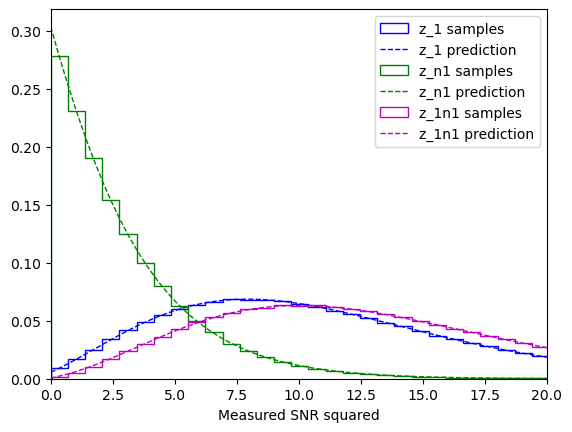

In [3]:
true_SNRs = [z_1, z_n1, z_1n1]
samples_list = [samples_1, samples_n1, samples_1n1]
dfs = [2,2,3]
legend = ['z_1', 'z_n1', 'z_1n1']
cs = ['b', 'g', 'm']

for i in range(len(true_SNRs)):
    _ = plt.hist(np.abs(samples_list[i])**2, histtype='step', density=True, bins=100, range=(0, np.max(np.abs(samples_list))**2), color=cs[i], label=f'{legend[i]} samples')
    m_SNR = np.linspace(1e-10, np.max(np.abs(samples_list[i])), 1001)
    pdf = ncx2.pdf(m_SNR**2, dfs[i], np.abs(true_SNRs[i])**2)
    plt.plot(m_SNR**2, pdf, c=cs[i], ls='dashed', lw=1, label=f'{legend[i]} prediction')
plt.legend()
plt.xlabel('Measured SNR squared')
plt.xlim(0, 20)
plt.show()

Three degrees of freedom does not match exactly, but it is very close.

In order to calculate the whether a given $\hat{\rho}$ is detectable we can use the highest posterior density (HPD). Applying this at an e.g. 90% level calculates the bounds containing 90% of the probability distribution with the minimum width. If these bounds include $\rho=0$, then the event is not detectable and vice versa.

For two degrees of freedom we apply this in $\rho^2$ space, which works well as for low values of $\hat{\rho}$ the pdf is non zero at $\rho=0$. For three degrees of freedom in $\rho^2$ space however we see that the pdf always goes to zero at $\rho=0$ for all values of $\hat{\rho}$. This means that the HPD will never include zero.

This happens because there are two competing effects close to $\rho=0$. For a distribution uniform in complex $z$ space, the area/volume corresponding to a ring/shell of constant $\rho$ as $1/\rho$ for two degrees of freedom, and $1/\rho^2$ for three degrees of freedom. When measuring in $\rho^2$ space, we must then multiply each by $\rho$. This cancels out the area effect for the former case, but not the full volume effect for the latter case.

Let us therefore take a look at applying this method in $\rho^3$ space for the phase consistent $z_{1,-1}$ with three degrees of freedom. We transform the pdf by using $p_y(y) = \left|\frac{dx}{dy}\right|p_x(x)$.

0.005554498269121154
0.3032653298563167
2.6880519410391516e-13


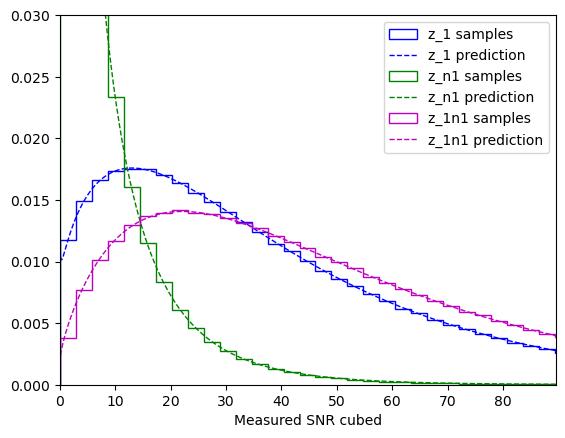

In [127]:
true_SNRs = [z_1, z_n1, z_1n1]
samples_list = [samples_1, samples_n1, samples_1n1]
dfs = [2,2,3]
legend = ['z_1', 'z_n1', 'z_1n1']
cs = ['b', 'g', 'm']

for i in range(len(true_SNRs)):
    _ = plt.hist(np.abs(samples_list[i])**3, histtype='step', density=True, bins=200, range=(0, np.max(np.abs(samples_list)**3)), color=cs[i], label=f'{legend[i]} samples')
    m_SNR = np.linspace(1e-10, np.max(np.abs(samples_list[i])), 1001)
    pdf = ncx2.pdf(m_SNR**2, dfs[i], np.abs(true_SNRs[i])**2)
    plt.plot(m_SNR**3, pdf*2/(3*m_SNR), c=cs[i], ls='dashed', lw=1, label=f'{legend[i]} prediction')
    print(pdf[0])
plt.legend()
plt.xlabel('Measured SNR cubed')
plt.xlim(0, 20**(3/2))
plt.ylim(0, 0.03)
plt.show()

The two distributions with two degrees of freedom blow up as $\rho \rightarrow 0$ as the area effect is 'overcorrected'. The $z_{1,-1}$ distribution with three degrees of freedom however is now has the volume effect exactly removed in $\rho^3$ space, and so we should be able to use the HPD as before.

In [117]:
# Gets 90% confidence bounds with x% cutoff from left
def get_CI(rv, x, CI=0.9):
    q = np.array([x, x+CI])
    CI_bounds = rv.ppf(q)
    pdf_ = rv.pdf(CI_bounds)
    return CI_bounds

# Gets 90% confidence bounds with shortest possible distance
def get_hpd(rv, CI=0.9):

    min_result = minimize(lambda x: abs(np.diff(get_CI(rv, x[0], CI=CI))[0]), (1-CI)/2, bounds=[(0,1-CI)])
    min_x = min_result['x'][0]

    return get_CI(rv, min_x, CI=CI)

Text(0.5, 1.0, 'Two degrees of freedom')

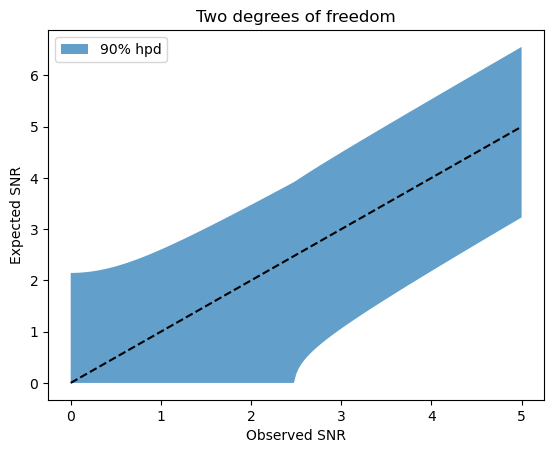

In [118]:
# Calculate 90% hpd bounds for dense array of observed SNRs
df = 2
hpd_bounds = []
obs_arr = np.linspace(0, 5, 201)
for obs in obs_arr:
    rv = ncx2(df, obs**2)
    hpd_bounds.append(get_hpd(rv, CI=0.9)**(1/df))
hpd_bounds = np.array(hpd_bounds)

# Make plot
plt.fill_between(obs_arr, hpd_bounds.T[0], hpd_bounds.T[1], alpha=0.7, label='90% hpd')
plt.plot(obs_arr, obs_arr, c='k', ls='dashed', zorder=3)
plt.legend(loc='upper left')
plt.xlabel('Observed SNR')
plt.ylabel('Expected SNR')
plt.title('Two degrees of freedom')

Unfortunately the custom random variable we have created is extremely slow to calculate the point percent function (ppf), meaning we cannot create plots like above for higher degrees of freedom with a reasonable computational cost.

We can however still optimize to find the 'SNR cutoff' by finding the point where $p(0) = p(0.9)$. In order to do this properly we should create a new custom random variable, with a pdf on $\rho^d$ where $d$ is the number of degrees of freedom. All we need to do this is to define the pdf.

In [324]:
# Define rv
class ncxdf_gen(rv_continuous):
    def _pdf(self, x, df, nc):
        if len(np.shape(x)) > 0:
            x = np.array(x)
            result = np.zeros_like(x)
            df = df[0]
            nc = nc[0]
            result[x>0] = ncx2.pdf(x[x>0]**(2/df), df, nc**(2/df))
            conv_factor = (2/df)*x[x>0]**(2/df-1)
            result[x>0] *= conv_factor
            return result
        elif x <= 0:
            return 0
        else:
            conv_factor = (2/df)*x**(2/df-1)
            return ncx2.pdf(x**(2/df), df, nc**(2/df))*conv_factor
ncxdf = ncxdf_gen(name='ncxdf')

In [122]:
# Function to be minimized
def compare_cutoff(x, nc_func, df, CI=0.9):
    CI_bounds = get_CI(nc_func(df, x**df), 1e-16, CI=CI)
    pdf_diff = abs(np.diff(nc_func.pdf(CI_bounds, df, x**df))[0])
    return pdf_diff

# Find cutoff SNR
def calc_cutoff_SNR(nc_func, df, CI=0.9):

    min_result = minimize(lambda x: compare_cutoff(x[0], nc_func, df, CI=CI), 2.5, bounds=[(0,10)],
                          method='Nelder-Mead', options={'xatol': 0.0001, 'fatol': np.inf})
    min_x = min_result['x'][0]

    return min_x

In [ ]:
start = time.time()
cutoff_2df = calc_cutoff_SNR(ncx2, 2)
end = time.time()
print(f'The SNR cutoff with two degrees of freedom is {cutoff_2df:.3f}.')
print(f'Calculated in {end-start:.2f} seconds.')

In [ ]:
start = time.time()
cutoff_2df = calc_cutoff_SNR(ncxdf, 2)
end = time.time()
print(f'The SNR cutoff with two degrees of freedom is {cutoff_2df:.3f}.')
print(f'Calculated in {end-start:.2f} seconds.')

In [319]:
start = time.time()
cutoff_3df = calc_cutoff_SNR(ncxdf, 3)
end = time.time()
print(f'The SNR cutoff with three degrees of freedom is {cutoff_3df:.3f}.')
print(f'Calculated in {end-start:.2f} seconds.')

The SNR cutoff with three degrees of freedom is 3.016.
Calculated in 297.00 seconds.


In [320]:
start = time.time()
cutoff_4df = calc_cutoff_SNR(ncxdf, 4)
end = time.time()
print(f'The SNR cutoff with four degrees of freedom is {cutoff_4df:.3f}.')
print(f'Calculated in {end-start:.2f} seconds.')

The SNR cutoff with four degrees of freedom is 3.451.
Calculated in 380.92 seconds.
